### Import Libraries

In [1]:
import numpy as np
import pandas as pd
from scipy import stats
from scipy.stats import norm, skew
import statsmodels.api as sm

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, RobustScaler, OneHotEncoder, PowerTransformer
from sklearn.impute import SimpleImputer

from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge

from sklearn.pipeline import make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.compose import ColumnTransformer

from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb

%matplotlib inline
color = sns.color_palette()
sns.set_style('darkgrid')

### Load Data

In [3]:
train = pd.read_csv('../data/01_raw/train.csv')
test = pd.read_csv('../data/01_raw/test.csv')

train.drop('Id',axis=1,inplace=True)
test.drop('Id',axis=1,inplace=True)

### EDA

In [4]:
train.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [5]:
train.shape

(1460, 80)

In [6]:
train.isnull().sum().sort_values(ascending=False).head(20)

PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
MasVnrType       872
FireplaceQu      690
LotFrontage      259
GarageYrBlt       81
GarageCond        81
GarageType        81
GarageFinish      81
GarageQual        81
BsmtExposure      38
BsmtFinType2      38
BsmtCond          37
BsmtQual          37
BsmtFinType1      37
MasVnrArea         8
Electrical         1
MSSubClass         0
dtype: int64

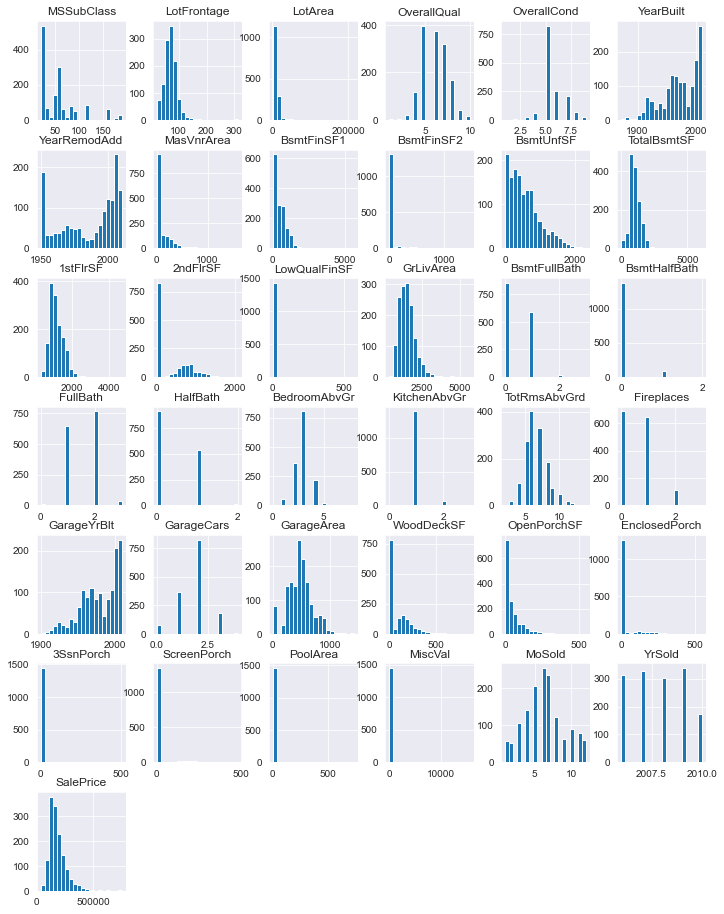

In [6]:
train.hist(figsize=(12,16),bins=20);

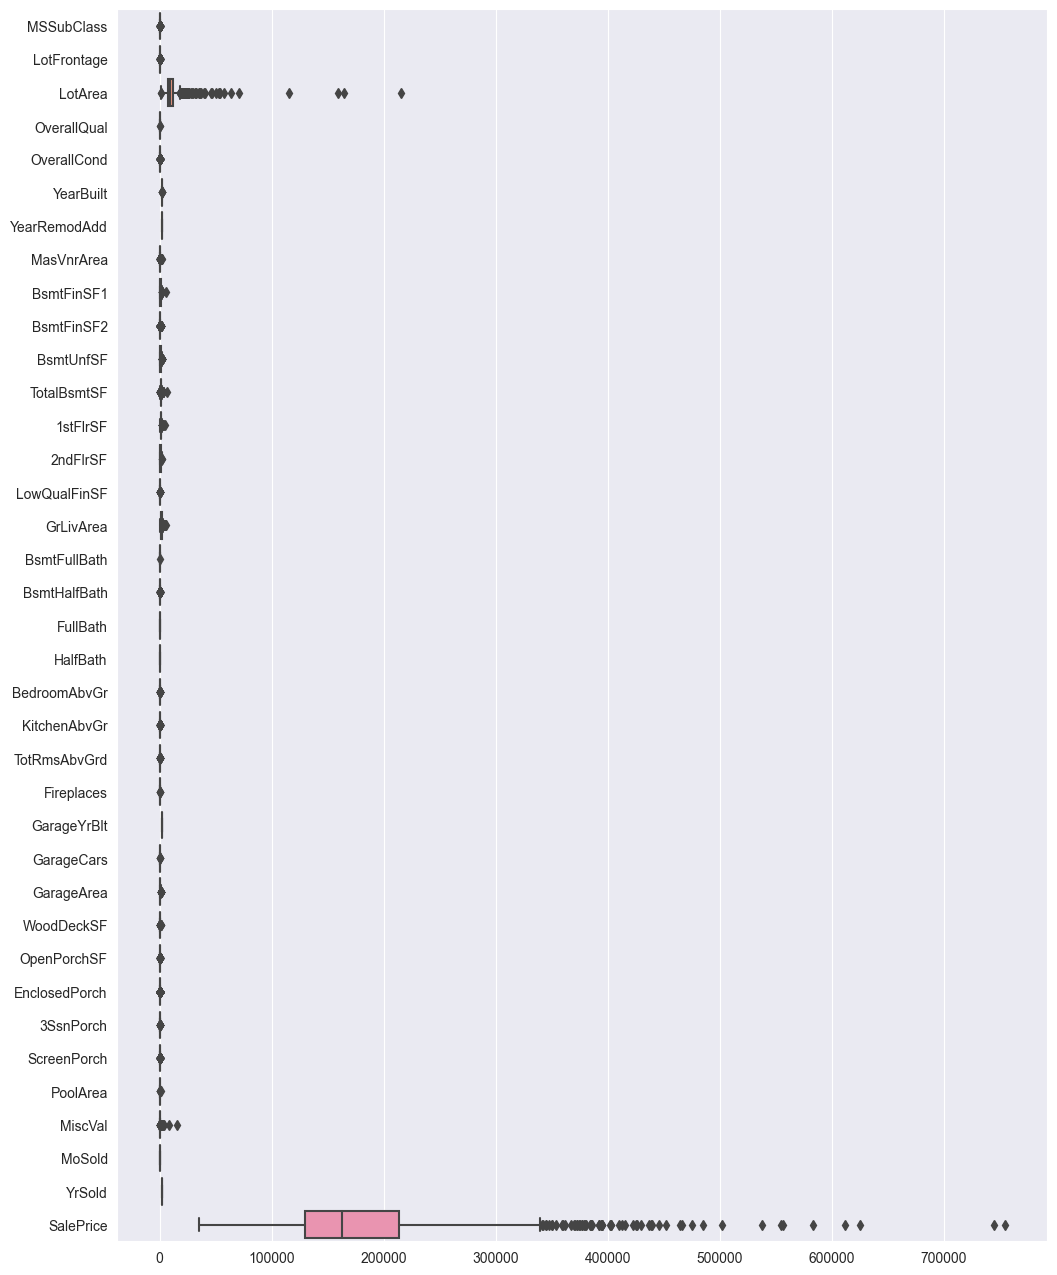

In [7]:
fig, ax = plt.subplots(figsize=(12,16))
sns.boxplot(data = train, orient='h')
plt.show()

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:2                                                                                    │
│                                                                                                  │
│   1 plt.subplots(figsize=(12,9))                                                                 │
│ ❱ 2 sns.heatmap(train.corr(), vmax=1, square=True)                                               │
│   3 plt.show()                                                                                   │
│   4                                                                                              │
│                                                                                                  │
│ /Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pandas/core/frame. │
│ py:10054 in corr                                                                                 │
│                                                                                                  │
│   10051 │   │   data = self._get_numeric_data() if numeric_only else self                        │
│   10052 │   │   cols = data.columns                                                              │
│   10053 │   │   idx = cols.copy()                                                                │
│ ❱ 10054 │   │   mat = data.to_numpy(dtype=float, na_value=np.nan, copy=False)                    │
│   10055 │   │                                                                                    │
│   10056 │   │   if method == "pearson":                                                          │
│   10057 │   │   │   correl = libalgos.nancorr(mat, minp=min_periods)                             │
│                                                                                                  │
│ /Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pandas/core/frame. │
│ py:1837 in to_numpy                                                                              │
│                                                                                                  │
│    1834 │   │   """                                                                              │
│    1835 │   │   if dtype is not None:                                                            │
│    1836 │   │   │   dtype = np.dtype(dtype)                                                      │
│ ❱  1837 │   │   result = self._mgr.as_array(dtype=dtype, copy=copy, na_value=na_value)           │
│    1838 │   │   if result.dtype is not dtype:                                                    │
│    1839 │   │   │   result = np.array(result, dtype=dtype, copy=False)                           │
│    1840                                                                                          │
│                                                                                                  │
│ /Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pandas/core/intern │
│ als/managers.py:1732 in as_array                                                                 │
│                                                                                                  │
│   1729 │   │   │   │   arr = arr.view()                                                          │
│   1730 │   │   │   │   arr.flags.writeable = False                                               │
│   1731 │   │   else:                                                                             │
│ ❱ 1732 │   │   │   arr = self._interleave(dtype=dtype, na_value=na_value)                        │
│   1733 │   │   │   # The underlying data was copied within _interleave, so no need               │
│   1734 │   │   │   # to further copy if copy=True or setting na_value                            │
│   1735                                                     

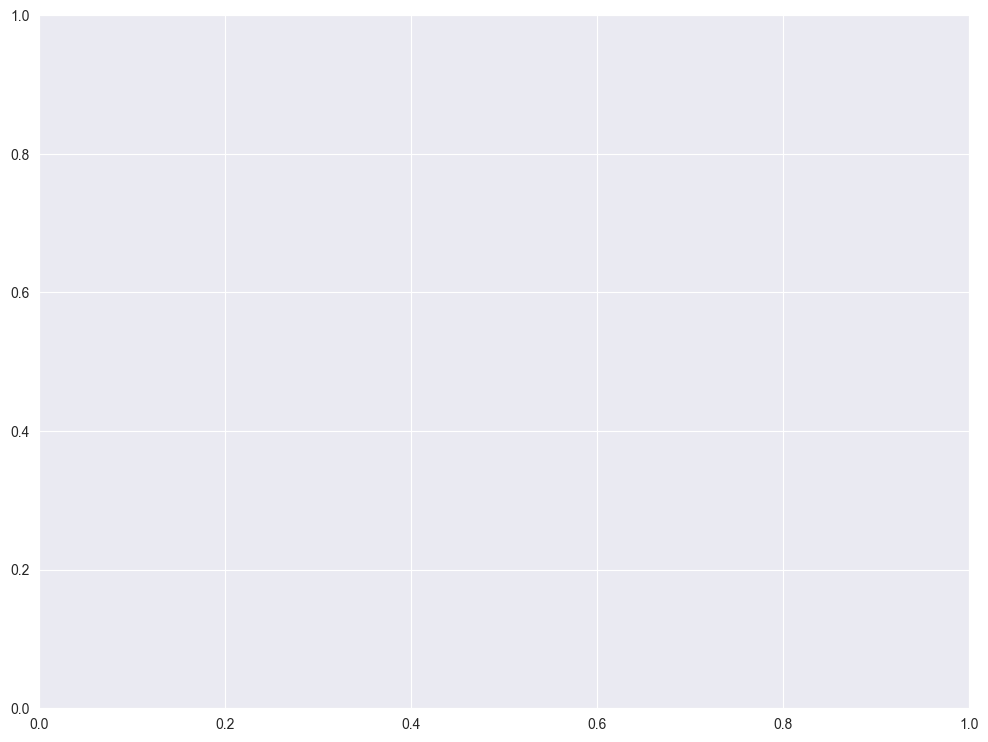

In [8]:
plt.subplots(figsize=(12,9))
sns.heatmap(train.corr(), vmax=1, square=True)
plt.show()

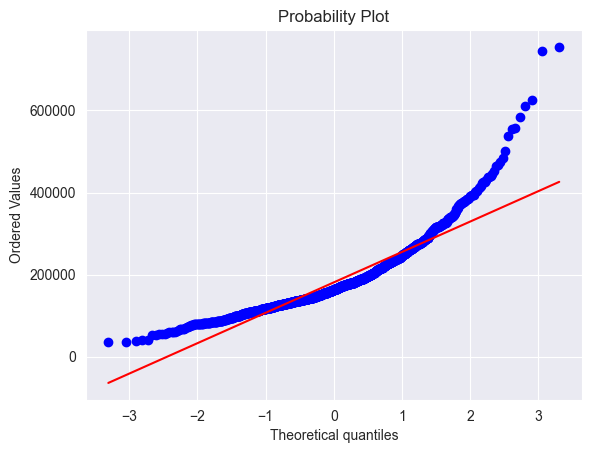

In [9]:
fig = plt.figure()
res = stats.probplot(train['SalePrice'], plot=plt)
plt.show()

### Create Skew Table

In [10]:
def create_skew_table(train):
    numeric_feats = train.dtypes[train.dtypes != "object"].index

    # Check the skew of all numerical features
    skewed_feats = train[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
    skewness = pd.DataFrame({'Skew' :skewed_feats})
    skewness = skewness.drop('SalePrice',axis=0)
    return skewness

In [11]:
skewness = create_skew_table(train)
skewness.head()

,Skew
MiscVal,24.451640
PoolArea,14.813135
LotArea,12.195142
3SsnPorch,10.293752
LowQualFinSF,9.002080


### Cleaning

In [14]:
parameters = {'outliers':{'GrLivArea':4000,
                         'SalePrice':300000},
             'cols_to_drop':['SalePrice','Utilities'],
             'none_cols':['PoolQC','MiscFeature','Alley','Fence','FireplaceQu','GarageType'
                         ,'GarageFinish','GarageQual','GarageCond','BsmtQual', 'BsmtCond', 
                         'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2','MasVnrType','MSSubClass'],
             'zero_cols':['GarageYrBlt', 'GarageArea', 'GarageCars','BsmtFinSF1', 
                          'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 
                          'BsmtHalfBath','MasVnrArea'],
             'mode_cols':['Functional','MSZoning','Electrical','KitchenQual','Exterior1st','Exterior2nd','SaleType'],
             'str_cols':['MSSubClass','OverallCond','YrSold','MoSold'],
             'label_enc_cols':['OverallCond']} 

In [15]:
def remove_outliers(train):
    train = train.copy()
    train = train.drop(train[(train['GrLivArea']>parameters['outliers']['GrLivArea']) & 
                             (train['SalePrice']<parameters['outliers']['SalePrice'])]
                       .index)
    return train


def create_target(train):
    y_train = np.log1p(train["SalePrice"])
    return y_train

def drop_cols(train):
    return train.drop(parameters['cols_to_drop'],axis=1)

def fill_na(train):
    train = train.copy()
    train[parameters['none_cols']] = train[parameters['none_cols']].fillna("None")
    train[parameters['zero_cols']] = train[parameters['zero_cols']].fillna(0)
    
    train["LotFrontage"] = train.groupby("Neighborhood")["LotFrontage"].transform(
                                        lambda x: x.fillna(x.median()))
    
    impute_int = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
    impute_str = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
    
    int_cols = train.select_dtypes(include='number').columns
    str_cols = train.select_dtypes(exclude='number').columns
    
    train[int_cols] = impute_int.fit_transform(train[int_cols])
    train[str_cols] = impute_str.fit_transform(train[str_cols])
    
    return train

def total_sf(train):
    train = train.copy()
    train['TotalSF'] = train['TotalBsmtSF'] + train['1stFlrSF'] + train['2ndFlrSF']
    return train

def to_str(train):
    train = train.copy()
    train[parameters['str_cols']]=train[parameters['str_cols']].astype(str)
    return train

def fix_skew(train, skew_table):
    skewed_feats = skew_table[abs(skew_table) > 0.75].dropna().index
    skewed_feats = [i for i in skewed_feats if i not in list(train.dtypes[train.dtypes=='object'].index)]
    skew_yj = PowerTransformer(method='yeo-johnson')
    train[skewed_feats] = skew_yj.fit_transform(train[skewed_feats])
    
    return train

def one_hot(train):
    ohe_cols = [i for i in list(train.dtypes[train.dtypes=='object'].index) if i not in parameters['label_enc_cols']]
    train[ohe_cols]=train[ohe_cols].astype(str)
    
    column_trans = ColumnTransformer(
        [('one_hot', OneHotEncoder(),ohe_cols)]
        ,remainder='passthrough',sparse_threshold=0)
    
    train = pd.DataFrame(column_trans.fit_transform(train),columns = column_trans.get_feature_names())
    
    return train

In [16]:
train2 = train.copy()
train2 = remove_outliers(train)

y_train = create_target(train2)

train2 = drop_cols(train2)
train2 = fill_na(train2)
train2 = total_sf(train2)
train2 = to_str(train2)
train2 = fix_skew(train2,skewness)
train2 = one_hot(train2)
train2 = train2.astype(float)


train2.head()
train2.dtypes

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:11                                                                                   │
│                                                                                                  │
│    8 train2 = total_sf(train2)                                                                   │
│    9 train2 = to_str(train2)                                                                     │
│   10 train2 = fix_skew(train2,skewness)                                                          │
│ ❱ 11 train2 = one_hot(train2)                                                                    │
│   12 train2 = train2.astype(float)                                                               │
│   13                                                                                             │
│   14                                                                                             │
│                                                                                                  │
│ in one_hot:61                                                                                    │
│                                                                                                  │
│   58 │   │   [('one_hot', OneHotEncoder(),ohe_cols)]                                             │
│   59 │   │   ,remainder='passthrough',sparse_threshold=0)                                        │
│   60 │                                                                                           │
│ ❱ 61 │   train = pd.DataFrame(column_trans.fit_transform(train),columns = column_trans.get_fe    │
│   62 │                                                                                           │
│   63 │   return train                                                                            │
│   64                                                                                             │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
AttributeError: 'ColumnTransformer' object has no attribute 'get_feature_names'

### Checks

In [15]:
train2.isnull().sum().sum()

0

In [16]:
train2.head()

,one_hot__x0_120.0,one_hot__x0_160.0,one_hot__x0_180.0,one_hot__x0_190.0,one_hot__x0_20.0,one_hot__x0_30.0,one_hot__x0_40.0,one_hot__x0_45.0,one_hot__x0_50.0,one_hot__x0_60.0,...,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,TotalSF
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,2.0,548.0,-0.949026,0.845196,-0.407921,-0.129369,-0.294004,-0.064282,-0.192313,2566.0
1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,2.0,460.0,1.214767,-1.070360,-0.407921,-0.129369,-0.294004,-0.064282,-0.192313,2524.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,2.0,608.0,-0.949026,0.671672,-0.407921,-0.129369,-0.294004,-0.064282,-0.192313,2706.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3.0,642.0,-0.949026,0.587679,2.454703,-0.129369,-0.294004,-0.064282,-0.192313,2473.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,3.0,836.0,1.081348,0.995396,-0.407921,-0.129369,-0.294004,-0.064282,-0.192313,3343.0


### Modelling

In [17]:
#Validation function
def rmsle_cv(model, X_train, y_train, n_folds=5):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(X_train.values)
    rmse= np.sqrt(-cross_val_score(model, X_train.values, y_train, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

In [18]:
lasso = make_pipeline(RobustScaler(), Lasso(alpha=0.0005, random_state=1))
rf = RandomForestRegressor(n_estimators=1000)
xgb_model = xgb.XGBRegressor(learning_rate=0.05, max_depth=3,  n_estimators=2000, nthread=-1)

In [19]:
def fit_model(model, X_train, y_train, n_folds=5):
    score = rmsle_cv(model, X_train, y_train, n_folds)

    model = model.fit(X_train,y_train)
    
    print("\nmodel score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))
    
    y_pred = model.predict(X_train)
    
    fig,ax = plt.subplots(ncols=3,figsize=(20,4))
    ax[0].hist(x=y_pred,bins=20)
    ax[1].scatter(x=y_train,y=y_pred)
    ax[1].axline([0, 0], [1, 1])
    sm.qqplot(y_pred, ax=ax[2], fit=True,line="45")
    plt.show()
    return model


model score: 0.1122 (0.0062)



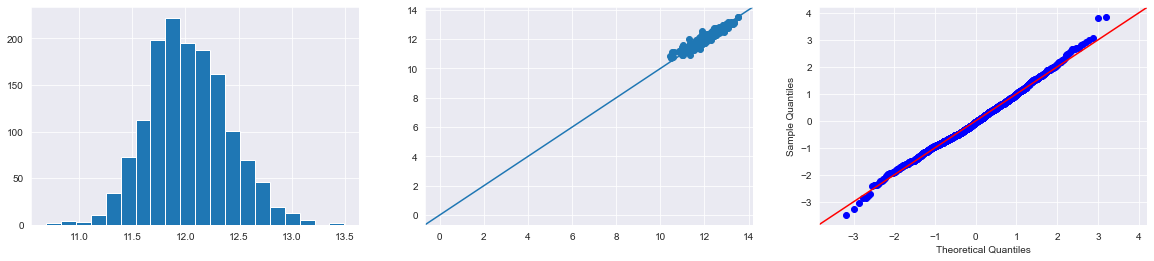

In [20]:
lasso_fit = fit_model(lasso,train2,y_train)


model score: 0.1381 (0.0045)



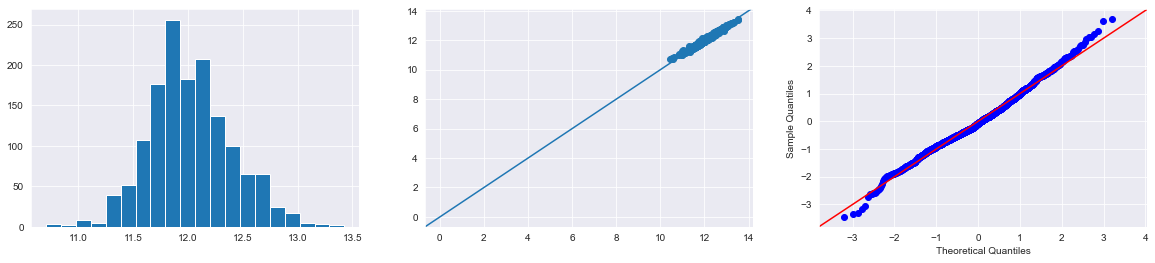

In [21]:
rf_fit = fit_model(rf,train2,y_train)


model score: 0.1194 (0.0077)



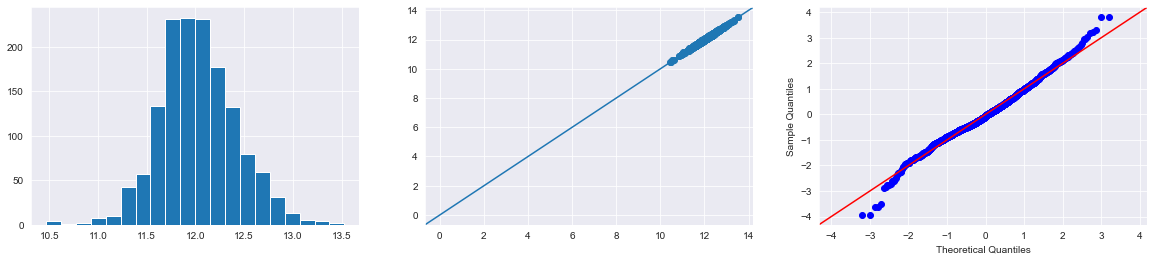

In [22]:
xgb_model_fit = fit_model(xgb_model,train2,y_train)

In [17]:
train

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1456,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1457,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,142125
